# Homework 4 
Name: Siddharth Iyer <br>
CWID: 10447455

## Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
import time

In [2]:
# decorator function to measure run time
def timeit(method):
    def timed(*args, **kwargs):
        ts = time.time()
        result = method(*args, **kwargs)
        te = time.time()
        if 'log_time' in kwargs:
            name = kwargs.get('log_name', method.__name__.upper())
            kwargs['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.22f ms' % (method.__name__, (te - ts) * 1000))
        return result
    return timed

## Problem 1. Barrier Options

**(a) Is such an option cheaper or more expensive than a vanilla put option? Explain.**

A barrier put option should be cheaper than a vanilla put option because there is an additional condition that increases the likelihood of expiring worthless. A vanilla put option will have fewer 0s at expiry in its Monte Carlo simulation, so naturally you would pay more when it is discounted.

**(b) Is the estimator $\hat{P_{n,m}}$ biased? Is it biased low or high? Explain.**

The estimator is biased high. Because the estimation relies on discrete GBM simulation, which tends to under-represent stock price due to discrete holding error, it will over-represent the put option value (K - S)+.

**(c) Use the parameters in the table below to compute an estimate of the price using (0.1) along with a 95% confidence interval. Use m = 63 and n equal to at least 100,000.**

In [3]:
nsims = 100000
discrete_freq = 252
S0 = 50
sig = .3
r = .05
K = 60
T = .25
H = 55
R = 5

In [4]:
def simulate_gbm_paths(nsims, S0, sig, mu, T, discrete_freq):
    '''
    nsims: number of simulations to produce
    S0: initial stock price
    sig: volatility expressed as a percentage
    mu: annualized drift expressed as a percentage
    r: interest rate
    T: time in years
    discrete_freq: number of discrete time intervals per increment of T (252 would be 1 trading year)
    '''
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    Xt = np.log(S0) + np.cumsum(( (mu - sig**2/2)*dt + sig*np.sqrt(dt) * np.random.normal(size=(nparts,nsims)) ), axis=0)
    Xt = np.exp(Xt)
    Xt = np.vstack([np.repeat(S0, nsims), Xt])

    return Xt

def barrier_option_pricing_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, optype = "uop"):
    gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)
    max_array = np.max(gbm_sim, axis=0)
    if optype == "uop":            
        return np.exp(-r*T) * np.sum((np.maximum(K - gbm_sim[-1], 0) * (max_array < H)*1)) * 1/nsims

In [5]:
gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)

In [6]:
fig = px.line(gbm_sim[:, 0:100], width=800, title = "GBM Simulation")
fig.show()
fig = px.histogram(np.max(gbm_sim, axis=0), width=800, nbins = 150, title="Maximum Value of Stock Process")
fig.show()

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\plotly\express\_core.py:1222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_output[col_name] = to_unindexed_series(df_input[argument])


In [7]:
barrier_option_pricing_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, optype="uop")

7.366737163679056

This Barrier option price is much higher than predicted...this proves that it is biased high. 

In [8]:
num_ops_sim = 120
barr_op_price = [barrier_option_pricing_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, optype="uop") for i in range(num_ops_sim)]

Confidence Interval (95%):  (7.3525341403683, 7.361437933288103)


(array([1., 0., 0., 3., 0., 1., 2., 1., 3., 3., 6., 2., 0., 5., 4., 6., 5.,
        5., 3., 5., 3., 5., 6., 2., 4., 3., 5., 8., 4., 1., 3., 1., 4., 0.,
        3., 4., 0., 0., 2., 4., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.]),
 array([7.30387728, 7.30631358, 7.30874987, 7.31118617, 7.31362246,
        7.31605876, 7.31849506, 7.32093135, 7.32336765, 7.32580394,
        7.32824024, 7.33067653, 7.33311283, 7.33554913, 7.33798542,
        7.34042172, 7.34285801, 7.34529431, 7.3477306 , 7.3501669 ,
        7.3526032 , 7.35503949, 7.35747579, 7.35991208, 7.36234838,
        7.36478468, 7.36722097, 7.36965727, 7.37209356, 7.37452986,
        7.37696615, 7.37940245, 7.38183875, 7.38427504, 7.38671134,
        7.38914763, 7.39158393, 7.39402022, 7.39645652, 7.39889282,
        7.40132911, 7.40376541, 7.4062017 , 7.408638  , 7.4110743 ,
        7.41351059, 7.41594689, 7.41838318, 7.42081948, 7.42325577,
        7.42569207]),
 <BarContainer object of 50 artists>)

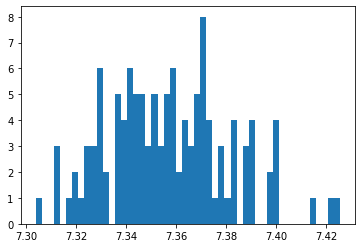

In [9]:
print("Confidence Interval (95%): ", st.t.interval(alpha=0.95, df=len(barr_op_price)-1, loc=np.mean(barr_op_price), scale=st.sem(barr_op_price)))
plt.hist(barr_op_price, bins=50)

**(d) An UOP with a rebate pays its holder a rebate R when the option is knocked out (i.e. when it hits the barrier). Explain carefully how you would extend the Monte Carlo estimator (0.1) to handle the case with a rebate.**

When the options first hits the barrier and crosses it, I would record the time at which it happens. In the code below, it's recorded in indx_hit_barrier. In this case, index $\times dt$ is the discount time. Next, I discount the rebates by $e^{-rt_{barrier}}$, and add it to the option vaule. 

In the code below, I use np.argmax to find the first index instance of crossing the barrier. Since each simulation will have a different discount time, we exponentiate -r*indx_hit_barrier_dt then multiply this vector by the indicator function for Rebates (1 if rebate occurs, 0 else).

Obviously it's still a highly biased above the real price, but this improves slowly as discrete_freq is increased. 

**(e) Use your estimator in part (d) to compute an estimate of the price an UOP with a rebate together with a 95%
confidence interval. Use the same parameters as in (c) and set the rebate to R = $5**

In [10]:
def barrier_option_pricing_w_rebate_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, R, optype = "uop"):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)
    max_array = np.max(gbm_sim, axis=0)
    indx_hit_barrier = np.argmax(gbm_sim > H, axis=0)
    if optype == "uop":
        return np.exp(-r*T) * np.sum((np.maximum(K - gbm_sim[-1], 0) * (max_array < H)*1)) * 1/nsims + \
            np.average(np.exp(-r * indx_hit_barrier * dt) * R * (indx_hit_barrier > 0)*1)

In [11]:
barrier_option_pricing_w_rebate_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, R)

9.732681695114698

In [12]:
num_ops_sim = 120
barr_op_price = [barrier_option_pricing_w_rebate_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, R, optype="uop") for i in range(num_ops_sim)]

Confidence Interval (95%):  (9.75043172018733, 9.756989158391935)


(array([2., 0., 1., 1., 0., 1., 2., 1., 4., 1., 4., 4., 1., 5., 1., 1., 3.,
        3., 2., 4., 4., 5., 5., 1., 7., 2., 6., 2., 5., 4., 4., 2., 4., 3.,
        3., 1., 5., 2., 3., 3., 2., 1., 1., 0., 1., 0., 0., 0., 1., 2.]),
 array([9.71409506, 9.71572664, 9.71735822, 9.71898981, 9.72062139,
        9.72225297, 9.72388455, 9.72551614, 9.72714772, 9.7287793 ,
        9.73041089, 9.73204247, 9.73367405, 9.73530564, 9.73693722,
        9.7385688 , 9.74020039, 9.74183197, 9.74346355, 9.74509514,
        9.74672672, 9.7483583 , 9.74998989, 9.75162147, 9.75325305,
        9.75488464, 9.75651622, 9.7581478 , 9.75977939, 9.76141097,
        9.76304255, 9.76467414, 9.76630572, 9.7679373 , 9.76956889,
        9.77120047, 9.77283205, 9.77446364, 9.77609522, 9.7777268 ,
        9.77935839, 9.78098997, 9.78262155, 9.78425314, 9.78588472,
        9.7875163 , 9.78914788, 9.79077947, 9.79241105, 9.79404263,
        9.79567422]),
 <BarContainer object of 50 artists>)

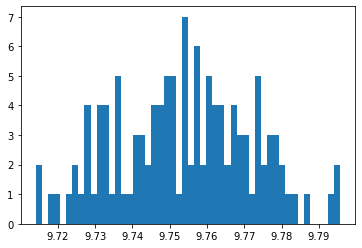

In [13]:
print("Confidence Interval (95%): ", st.t.interval(alpha=0.95, df=len(barr_op_price)-1, loc=np.mean(barr_op_price), scale=st.sem(barr_op_price)))
plt.hist(barr_op_price, bins=50)

## Problem 2. Reduction of the bias

**(a) Use this estimator to give an estimate of the UOP option price with a 95% confidence interval. Is it different from the interval in Problem 1(c)?**

In [16]:
def barrier_option_pricing_unbiased_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, optype = "uop"):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)
    # max_array = np.max(gbm_sim, axis=0)
    # indx_hit_barrier = np.argmax(gbm_sim > H, axis=0)
    if optype == "uop":
        P = np.exp(((2/sig**2) / T * np.log(H / S0) * np.log(gbm_sim[-1]/H)))
        return np.exp(-r*T) * np.sum(np.maximum(K - gbm_sim[-1], 0) * (1 - P)) * 1/nsims

In [17]:
barrier_option_pricing_unbiased_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H)

6.7571335824284375

In [18]:
num_ops_sim = 120
barr_unbiased_op_price = [barrier_option_pricing_unbiased_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, optype="uop") for i in range(num_ops_sim)]

Confidence Interval (95%):  (6.753270757480954, 6.761166454425186)


(array([2., 0., 1., 1., 0., 1., 0., 2., 2., 3., 1., 0., 4., 5., 3., 4., 1.,
        2., 5., 4., 7., 7., 3., 4., 6., 3., 6., 9., 4., 5., 4., 4., 4., 1.,
        4., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.]),
 array([6.70417003, 6.70647577, 6.70878152, 6.71108726, 6.71339301,
        6.71569875, 6.71800449, 6.72031024, 6.72261598, 6.72492172,
        6.72722747, 6.72953321, 6.73183896, 6.7341447 , 6.73645044,
        6.73875619, 6.74106193, 6.74336767, 6.74567342, 6.74797916,
        6.75028491, 6.75259065, 6.75489639, 6.75720214, 6.75950788,
        6.76181362, 6.76411937, 6.76642511, 6.76873086, 6.7710366 ,
        6.77334234, 6.77564809, 6.77795383, 6.78025958, 6.78256532,
        6.78487106, 6.78717681, 6.78948255, 6.79178829, 6.79409404,
        6.79639978, 6.79870553, 6.80101127, 6.80331701, 6.80562276,
        6.8079285 , 6.81023424, 6.81253999, 6.81484573, 6.81715148,
        6.81945722]),
 <BarContainer object of 50 artists>)

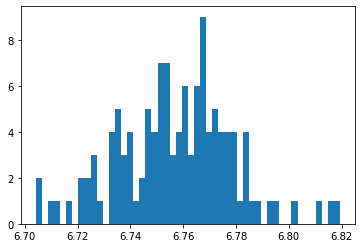

In [19]:
print("Confidence Interval (95%): ", st.t.interval(alpha=0.95, df=len(barr_unbiased_op_price)-1, loc=np.mean(barr_unbiased_op_price), scale=st.sem(barr_unbiased_op_price)))
plt.hist(barr_unbiased_op_price, bins=50)

We can see that the interval is about the same size but is much less biased than problem (c).

**(b) Use the barrier crossing formula (0.2) to construct an estimator for the price of an UOP option with a rebate that improves the estimator in Problem 1(d). Clearly explain your simulation procedure.Use your estimator to given an estimate of the rebate option price and a 95% confidence interval. Is it different from the interval in Problem 1(e)?**

We already know from the previous part (a), we can use probability to replace it with an unbiased estimator. 

In [45]:
def barrier_option_pricing_unbiased_w_rebate_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, R, optype = "uop"):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)
    # max_array = np.max(gbm_sim, axis=0)
    indx_hit_barrier = np.argmax(gbm_sim > H, axis=0)
    if optype == "uop":
        P = np.exp(((2/sig**2) / T * np.log(H / S0) * np.log(gbm_sim[-1]/H)))
        return np.exp(-r*T) * np.sum(np.maximum(K - gbm_sim[-1], 0) * (1 - P)) * 1/nsims +\
            np.average(np.exp(-r * indx_hit_barrier * dt) * R * (indx_hit_barrier > 0)*1)

In [46]:
barrier_option_pricing_unbiased_w_rebate_monte_carlo(nsims, S0, sig, r, T, discrete_freq, H, R, optype = "uop")

9.120949923527103

**(c) For an UOP without rebate, one can use the estimator in Problem 1(a). The only difference is that the stock price paths have to be simulated step by step using the Euler discretization scheme. Explain clearly how the barrier crossing formula (0.2) can be used to improve this estimator.**

## Problem 3. Asian Options

(i) Reimann sum and (ii) Brownian Bridge

In [112]:
nsims = 50000
S0 = 100
sig = .2
r = .09
K = 100
T = 1
discrete_freq = 252

In [103]:
def asian_option_price_reimann_monte_carlo(nsims, S0, sig, r, K, T, discrete_freq):
    gbm_sim = simulate_gbm_paths(nsims, S0, sig, r, T, discrete_freq)
    avg_price_vec = np.average(gbm_sim, axis=0)
    return np.exp(-r*T)*np.average(np.maximum(avg_price_vec - K,0))

In [108]:
asian_option_price_reimann_monte_carlo(nsims, S0, sig, r, K, T, discrete_freq)

6.763287308615354

In [95]:
def asian_option_price_bridge_monte_carlo(nsims, S0, sig, r, K, T, discrete_freq, m):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    dW = np.random.normal(size=(nparts,nsims))
    Wt = np.cumsum(dW, axis = 0)
    Xt = np.log(S0) + np.cumsum(( (r - sig**2/2)*dt + sig*np.sqrt(dt) * dW ), axis=0)
    Xt = np.exp(Xt)
    Xt = np.vstack([np.repeat(S0, nsims), Xt])
    Abb = np.sum(((np.random.normal(size=(nparts,nsims)) * np.sqrt((dt**3)/12) + dt/2*dW) * sig + r*(dt**2)/2 + dt) * Xt[1:], axis = 0)*1/T
    return np.average(np.maximum(Abb - K, 0)) * np.exp(-r*T)

In [113]:
asian_option_price_bridge_monte_carlo(nsims, S0, sig, r, K, T, discrete_freq)

7.057474372492751